# Jupyter notebook for plotting the results of live imaging, transmitted light, shape analysis

### Judith Pineau, November 2023, Physics of biological functions Unit, Institut Pasteur, Paris



### Here, for Experiment 1 of the Size Project

In [14]:
# Initiating - loading packages

import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
from glob import glob
import json
import sys, os
print(sys.path)
print(sys.executable)
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.rcParams.update({'font.size': 15})


sys.path.insert(0, r"\\zeus.pasteur.fr\Pbf1_Zeus\Judith\Bash\Python_scripts")  #Path to where the functions (JP_Generate_plots_timelapse_BF_analysis.py file) are
from JP_Generate_plots_timelapse_BF_analysis import *


['\\\\zeus.pasteur.fr\\Pbf1_Zeus\\Judith\\Bash\\Python_scripts', 'C:\\Users\\Judith\\Documents\\Analysis_Code', 'C:\\Users\\Judith\\Anaconda3\\python39.zip', 'C:\\Users\\Judith\\Anaconda3\\DLLs', 'C:\\Users\\Judith\\Anaconda3\\lib', 'C:\\Users\\Judith\\Anaconda3', '', 'C:\\Users\\Judith\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\Judith\\Anaconda3\\lib\\site-packages', 'C:\\Users\\Judith\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\Judith\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Judith\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Judith\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Judith\\.ipython']
C:\Users\Judith\Anaconda3\python.exe


In [39]:
def col_diff_Major_Minor(df):
    
    df_analysis = df.copy()
    df_analysis.insert(0,"diff_Major_Minor", " ")

    for i in range(0,len(df_analysis)):
        Major = df_analysis.at[i,'Major_Axis_um']
        AR = df_analysis.at[i,'AR']
        diff_Major_Minor = []
        for j in range(len(Major)):
            diff_Major_Minor.append(Major[j]-(Major[j] / AR[j]))
        
        df_analysis.at[i,'diff_Major_Minor'] =  diff_Major_Minor
    
    return df_analysis

In [41]:
## Here, I take all the .json files and put tham into one unique dataframe, where each row is a gastruloid

# Put the path to all the json shape files
path_to_json = r'\\zeus.pasteur.fr\Pbf1_Zeus\Judith\TL_BrightField_IsmaProject\20230509_Ol_4x_TLBF_Allsize\stitched\Z_select\20231009_dataframes_shape'
from glob import glob


# import all files from folder which ends with .json 
json_files = glob(os.path.join(path_to_json,'*shape.json'))

df = pd.DataFrame({'Exp_Date': pd.Series(dtype='str'),
                     'Path_data': pd.Series(dtype='str'),
                     'Name': pd.Series(dtype='str'),
                     'Well_ID': pd.Series(dtype='str'),
                     'Condition': pd.Series(dtype='str'),
                     'Replicate': pd.Series(dtype='str'),
                     'Keep_image': pd.Series(dtype='object'),
                     'Microscope': pd.Series(dtype='str'),
                     'Objective': pd.Series(dtype='int'),
                     'Pixel_size': pd.Series(dtype='float'),
                     'TimePt': pd.Series(dtype='object'),
                     'Border': pd.Series(dtype='str'),
                     'Area': pd.Series(dtype='object'),
                     'MA_length_um': pd.Series(dtype='object'),
                     'Solidity': pd.Series(dtype='object'),
                     'AR': pd.Series(dtype='object'),
                     'Major_Axis_um': pd.Series(dtype='object'),
                     })

for i in range(0,len(json_files)):
    
    df_i = pd.read_json(json_files[i], orient='columns')
    df_i = df_GiveID_Olympus(df_i,'Well')
    
    Area = df_i['Area'].to_numpy()
    AR= df_i['AR'].to_numpy()
    Major_Axis_um= df_i['Major_Axis_um'].to_numpy()
    MA_length_um= df_i['MA_length_um'].to_numpy()
    TimePt= df_i['TimePt'].to_numpy()
    
    df.at[i,'Name'] = df_i.at[0,'Name']
    df.at[i,'Well_ID'] = df_i.at[0,'Well_ID']
    df.at[i,'Condition'] = df_i.at[0,'Condition']
    df.at[i,'Replicate'] = df_i.at[0,'Replicate']
    df.at[i,'Exp_Date'] = df_i.at[0,'Exp_Date']
    df.at[i,'Path_data'] = df_i.at[0,'Path_data']

    
    df.at[i,'Area'] = [Area]
    df.at[i,'AR'] = [AR]
    df.at[i,'Major_Axis_um'] = [Major_Axis_um]
    df.at[i,'MA_length_um'] = [MA_length_um]
    df.at[i,'TimePt'] = [TimePt]

# Getting the number of time points, and there values

Time = df.loc[0,'TimePt'][0]
n_times = len(Time)
n_times


# Adding the difference between major and minor axis
df_analysis2 = col_diff_Major_Minor(df)




In [42]:

#I made a mistake during the analysis and the 1800 cells have been marked as 180, so I correct it here
df_analysis2.loc[ df_analysis2['Condition'] =='180cells', 'Condition'] = '1800cells' ## I made a mistake when doing the analysis of 1800 cells

In [43]:


def get_condition_as_num(cond_str):
    
    cond_sub = cond_str[0:-5]
    cond_sub = int(cond_sub)
    return cond_sub
    


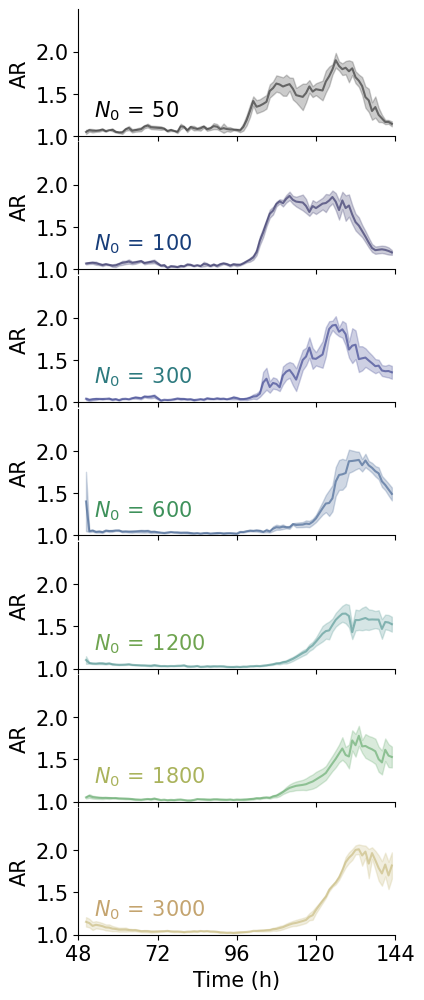

In [16]:
#Plotting with shift - proper filtering - not the 2400cells

#### First I need to reshape the data to be compatible with the seaborn format
df_analysis = df_analysis2.copy()
df_analysis['Condition_int'] = df_analysis['Condition'].apply(get_condition_as_num) # I need the conditions to be numerical values 

Cond_list = np.array([50,100,300,600,1200,1800,3000]) 
N_cond = Cond_list.size 



# VARIABLE TO PLOT - in time
Colname = 'Major_Axis_um'
Colname = 'AR'



n_t = len(Time)
ID_tot = np.empty(n_t*len(df_analysis), dtype='object')
V_tot = np.empty(n_t*len(df_analysis), dtype='object')
Cond_tot = np.empty(n_t*len(df_analysis), dtype='object')
Time_h_tot = np.empty(n_t*len(df_analysis), dtype='object')

n=0

for i in range(0,N_cond):
    R_i = df_analysis.loc[df_analysis['Condition_int']==Cond_list[i],Colname]
    R_i = R_i.values.tolist()
    P_i = np.empty((len(R_i),n_times))
    Well_list = df_analysis.loc[df_analysis['Condition_int']==Cond_list[i],'Well_ID']
    Well_list = Well_list.values.tolist()
    W_ID = np.array(Well_list,dtype=str)
    
    for j in range (0,len(R_i)):
        if (R_i[j]!=None):
            #P_i[j,:] = R_i[j][0]
            P_temp = R_i[j][0]
            nan_idx = np.isnan(P_temp[:])
            P_temp = P_temp[~np.isnan(P_temp)]
            peaks,_ = scipy.signal.find_peaks(P_temp,prominence=0.2)
            P_temp[peaks]=np.nan 
            P_temp = np.insert(P_temp,np.where(nan_idx)[0],np.nan)
            P_i[j,:] = P_temp
            
    median_10 = np.nanmedian(P_i[:,0:10])
    med = np.nanmedian(P_i[:,0:10],axis=1)
    out1 = med<median_10/10
    out2 = med>median_10*10
    P_i[out1,:] = np.nan
    P_i[out2,:] = np.nan
    P= P_i[~np.isnan(P_i).all(axis=1),:]

    W_ID[out1] = 'N'
    W_ID[out2] = 'N'
    W_ID_in = np.delete(W_ID, np.argwhere(W_ID == 'N'))
    
    n_t = P.shape[1]
    
    IDs = np.tile(W_ID_in, n_t)
    V = np.reshape(P, ( n_t*len(W_ID_in)))
    Cond = np.full(n_t*len(W_ID_in),Cond_list[i])
    Time_h = np.tile(Time,len(W_ID_in))
    
    ID_tot[n:n+n_t*len(W_ID_in)] = IDs
    V_tot[n:n+n_t*len(W_ID_in)] = V
    Cond_tot[n:n+n_t*len(W_ID_in)] = Cond
    Time_h_tot[n:n+n_t*len(W_ID_in)] = Time_h
    

    n = n + n_t*len(W_ID_in)

	
df_plot = pd.DataFrame({'Well_ID': ID_tot[0:n], 'Condition_int': Cond_tot[0:n], 'Time (h)': Time_h_tot[0:n], Colname:V_tot[0:n]})




# colors = plt.cm.gist_earth(np.linspace(0,0.8,N_cond))
# sns.set_palette(colors)
g = sns.FacetGrid(df_plot, row="Condition_int", hue="Condition_int", aspect=3, height=1.5, palette=colors)


g.map(sns.lineplot,"Time (h)", "AR","Condition_int",errorbar='se',alpha=0.5,hue='Condition_int',hue_norm=(50,4000),palette = 'gist_earth')
g.set(xlim=(48, 144), ylim=(1, 2.5), xticks=[48, 72, 96, 120, 144], yticks=[1, 1.5, 2.0])
colors=[]
for n in df_plot.Condition_int.unique():
    colors.append(plt.cm.gist_earth((n-50)/4000))
sns.set_palette(colors)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.05, .2, '$N_0\,=\,$' + label, fontweight="normal", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Time (h)")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=+.05)

# Remove axes details that don't play well with overlap
g.set_titles("")
 

name = '20230509_Exp1_Cut_shiftVertical2_SelectCond_bis_betterFilt'+Colname

#plt.savefig(name)

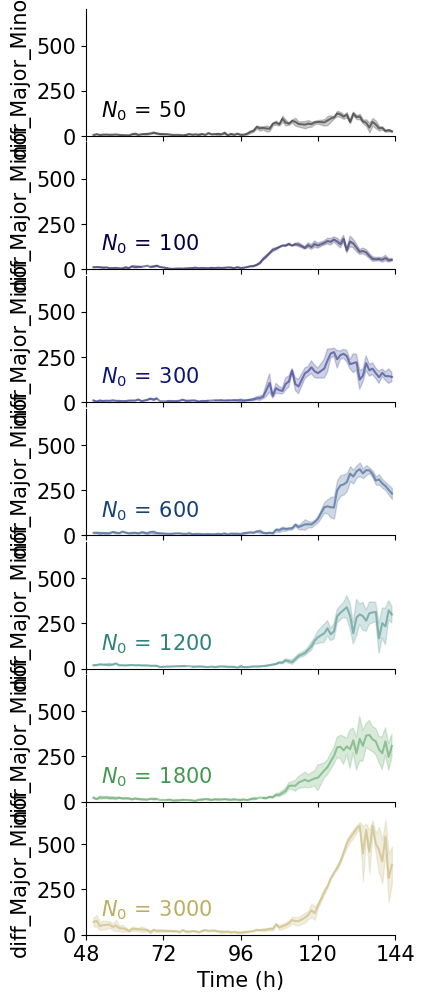

In [46]:
#Plotting with shift - proper filtering - not the 2400cells

#### First I need to reshape the data to be compatible with the seaborn format
df_analysis = df_analysis2.copy()
df_analysis['Condition_int'] = df_analysis['Condition'].apply(get_condition_as_num) # I need the conditions to be numerical values 

Cond_list = np.array([50,100,300,600,1200,1800,3000]) 
N_cond = Cond_list.size 



# VARIABLE TO PLOT - in time
Colname = 'Major_Axis_um'
Colname = 'AR'
Colname = 'diff_Major_Minor'

n_t = len(Time)
ID_tot = np.empty(n_t*len(df_analysis), dtype='object')
V_tot = np.empty(n_t*len(df_analysis), dtype='object')
Cond_tot = np.empty(n_t*len(df_analysis), dtype='object')
Time_h_tot = np.empty(n_t*len(df_analysis), dtype='object')

n=0

for i in range(0,N_cond):
    R_i = df_analysis.loc[df_analysis['Condition_int']==Cond_list[i],Colname]
    R_i = R_i.values.tolist()
    P_i = np.empty((len(R_i),n_times))
    Well_list = df_analysis.loc[df_analysis['Condition_int']==Cond_list[i],'Well_ID']
    Well_list = Well_list.values.tolist()
    W_ID = np.array(Well_list,dtype=str)
    
    for j in range (0,len(R_i)):
        if (R_i[j]!=None):
            #P_i[j,:] = R_i[j][0]
            P_temp = R_i[j][0]
            nan_idx = np.isnan(P_temp[:])
            P_temp = P_temp[~np.isnan(P_temp)]
            peaks,_ = scipy.signal.find_peaks(P_temp,prominence=0.2)
            P_temp[peaks]=np.nan 
            P_temp = np.insert(P_temp,np.where(nan_idx)[0],np.nan)
            P_i[j,:] = P_temp
            
    median_10 = np.nanmedian(P_i[:,0:10])
    med = np.nanmedian(P_i[:,0:10],axis=1)
    out1 = med<median_10/10
    out2 = med>median_10*10
    P_i[out1,:] = np.nan
    P_i[out2,:] = np.nan
    P= P_i[~np.isnan(P_i).all(axis=1),:]

    W_ID[out1] = 'N'
    W_ID[out2] = 'N'
    W_ID_in = np.delete(W_ID, np.argwhere(W_ID == 'N'))
    
    n_t = P.shape[1]
    
    IDs = np.tile(W_ID_in, n_t)
    V = np.reshape(P, ( n_t*len(W_ID_in)))
    Cond = np.full(n_t*len(W_ID_in),Cond_list[i])
    Time_h = np.tile(Time,len(W_ID_in))
    
    ID_tot[n:n+n_t*len(W_ID_in)] = IDs
    V_tot[n:n+n_t*len(W_ID_in)] = V
    Cond_tot[n:n+n_t*len(W_ID_in)] = Cond
    Time_h_tot[n:n+n_t*len(W_ID_in)] = Time_h
    

    n = n + n_t*len(W_ID_in)

	
df_plot = pd.DataFrame({'Well_ID': ID_tot[0:n], 'Condition_int': Cond_tot[0:n], 'Time (h)': Time_h_tot[0:n], Colname:V_tot[0:n]})




# colors = plt.cm.gist_earth(np.linspace(0,0.8,N_cond))
# sns.set_palette(colors)
g = sns.FacetGrid(df_plot, row="Condition_int", hue="Condition_int", aspect=3, height=1.5, palette=colors)


g.map(sns.lineplot,"Time (h)", Colname,"Condition_int",errorbar='se',alpha=0.5,hue='Condition_int',hue_norm=(50,4000),palette = 'gist_earth')
g.set(xlim=(48, 144), ylim=(0, 700), xticks=[48, 72, 96, 120, 144], yticks=[0, 250, 500])
colors=[]
for n in df_plot.Condition_int.unique():
    colors.append(plt.cm.gist_earth((n-50)/4000))
sns.set_palette(colors)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.05, .2, '$N_0\,=\,$' + label, fontweight="normal", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Time (h)")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=+.05)

# Remove axes details that don't play well with overlap
g.set_titles("")
 

name = '20230509_Exp1_Cut_shiftVertical2_SelectCond_bis_betterFilt'+Colname

#plt.savefig(name)

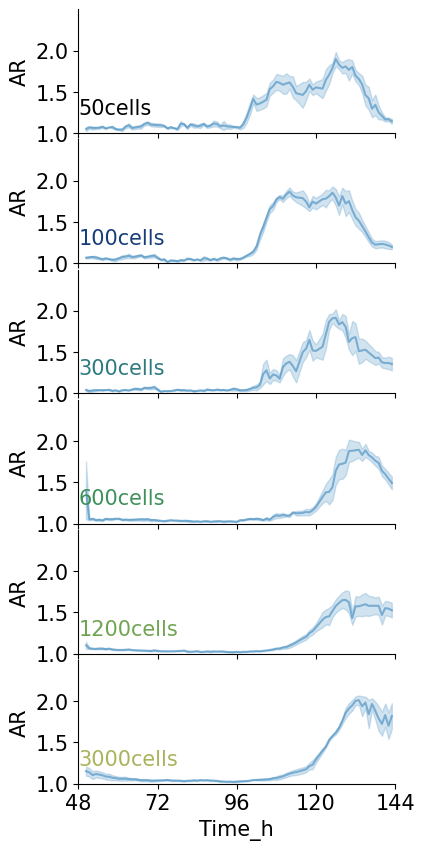

In [13]:
#Plotting with shift - peak filtering

#### First I need to reshape the data to be compatible with the seaborn format
df_analysis = df_analysis2.copy()
Cond_list = np.array(['50cells','100cells','300cells','600cells','1200cells','1800cells','3000cells'])
N_cond = Cond_list.size 


# VARIABLE TO PLOT - in time
Colname = 'Major_Axis_um'
Colname = 'AR'


n_t = len(Time)
ID_tot = np.empty(n_t*len(df_analysis), dtype='object')
V_tot = np.empty(n_t*len(df_analysis), dtype='object')
Cond_tot = np.empty(n_t*len(df_analysis), dtype='object')
Time_h_tot = np.empty(n_t*len(df_analysis), dtype='object')

n=0

for i in range(0,N_cond):
    R_i = df_analysis.loc[df_analysis['Condition']==Cond_list[i],Colname]
    R_i = R_i.values.tolist()
    P_i = np.empty((len(R_i),n_times))
    Well_list = df_analysis.loc[df_analysis['Condition']==Cond_list[i],'Well_ID']
    Well_list = Well_list.values.tolist()
    W_ID = np.array(Well_list, dtype=str)
    
    for j in range (0,len(R_i)):
        if (R_i[j]!=None):
            #P_i[j,:] = R_i[j][0]
            P_temp = R_i[j][0]
            nan_idx = np.isnan(P_temp[:])
            P_temp = P_temp[~np.isnan(P_temp)]
            peaks,_ = scipy.signal.find_peaks(P_temp,prominence=0.2)
            P_temp[peaks]=np.nan 
            P_temp = np.insert(P_temp,np.where(nan_idx)[0],np.nan)
            P_i[j,:] = P_temp
                        
    median_10 = np.nanmedian(P_i[:,0:10])
    med = np.nanmedian(P_i[:,0:10],axis=1)
    out1 = med<median_10/10
    out2 = med>median_10*10
    P_i[out1,:] = np.nan
    P_i[out2,:] = np.nan
    P= P_i[~np.isnan(P_i).all(axis=1),:]
    
    W_ID[out1] = 'N'
    W_ID[out2] = 'N'
    W_ID_in = np.delete(W_ID, np.argwhere(W_ID == 'N'))
    
    n_t = P.shape[1]
    
    IDs = np.tile(W_ID_in, n_t)
    V = np.reshape(P, ( n_t*len(W_ID_in)))
    Cond = np.full(n_t*len(W_ID_in),Cond_list[i])
    Time_h = np.tile(Time,len(W_ID_in))
    
    ID_tot[n:n+n_t*len(W_ID_in)] = IDs
    V_tot[n:n+n_t*len(W_ID_in)] = V
    Cond_tot[n:n+n_t*len(W_ID_in)] = Cond
    Time_h_tot[n:n+n_t*len(W_ID_in)] = Time_h
    

    n = n + n_t*len(W_ID_in)

	
df_plot = pd.DataFrame({'Well_ID': ID_tot[0:n], 'Condition': Cond_tot[0:n], 'Time_h': Time_h_tot[0:n], Colname:V_tot[0:n]})




colors = plt.cm.gist_earth(np.linspace(0,0.8,N_cond))

g = sns.FacetGrid(df_plot, row="Condition", hue="Condition", aspect=3, height=1.5, palette=colors)


g.map(sns.lineplot,"Time_h", "AR","Condition",errorbar='se',alpha=0.5)
g.set(xlim=(48, 144), ylim=(1, 2.5), xticks=[48, 72, 96, 120, 144], yticks=[1, 1.5, 2.0])
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="normal", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Time_h")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=+.05)

# Remove axes details that don't play well with overlap
g.set_titles("")
 

name = '20231002_Exp1_Cut_shiftVertical_2_reAnalysis'+Colname

#plt.savefig(name)

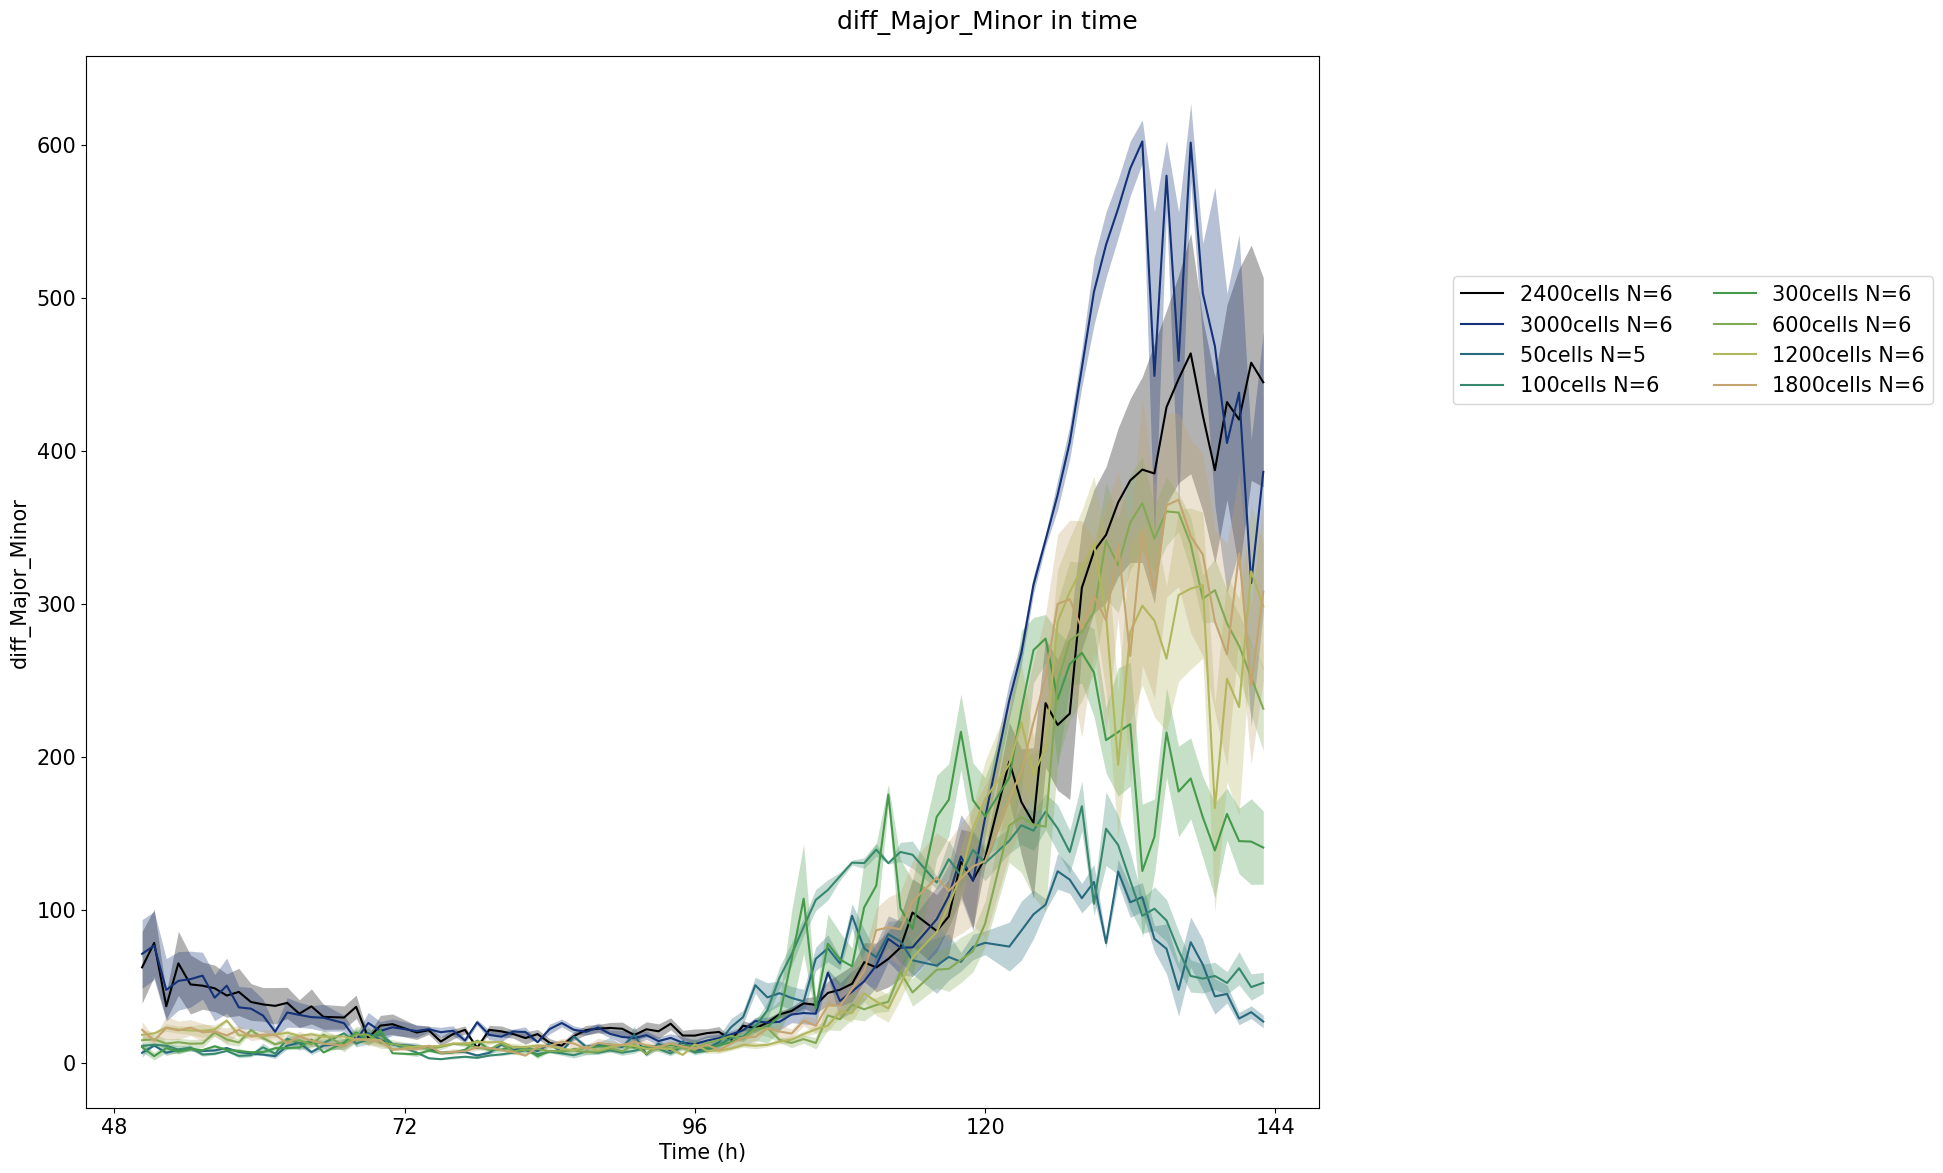

In [46]:
import matplotlib.ticker as ticker

tick_spacing=24

x = np.arange(0,n_times)
x=Time
fig, axs = plt.subplots(1,figsize=(20,12))

colors = plt.cm.Blues(np.linspace(0.5,1,N_cond))
colors = plt.cm.gist_earth(np.linspace(0,0.8,N_cond))

#colors = plt.cm.cividis(np.linspace(0,1,N_cond))

axs.set_xlabel('Time (h)')
axs.set_ylabel(Colname, color='k')
for j in range(0,N_cond):
    
    axs.plot(x, Mean_time[j,:], color=colors[j], label=Cond_list[j]+' N='+str(N_gastru[j]))
    axs.fill_between(x, (Mean_time[j,:]-SEM_time[j,:]), (Mean_time[j,:]+ SEM_time[j,:]),alpha=0.3, edgecolor=colors[j], facecolor=colors[j],linewidth=0)

#axs.legend(loc='best', shadow=False, fontsize='large')
axs.legend(loc='best', bbox_to_anchor=(1.1, 0.8),fancybox=True, shadow=False, ncol=2)
#axs.xticks(np.arange(int(min(x)), int(max(x))+1, 24))
axs.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#axs.legend(loc='center right',fancybox=True, shadow=False, ncol=2)

axs.tick_params(axis='y', labelcolor='k')


fig.suptitle(Colname+' in time')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
name = '20230716_Exp4_Cut_'+Colname
#figsave(fig, name)



In [31]:
print(Cond)

['2400cells' '3000cells' '50cells' '100cells' '300cells' '600cells'
 '1200cells' '1800cells']


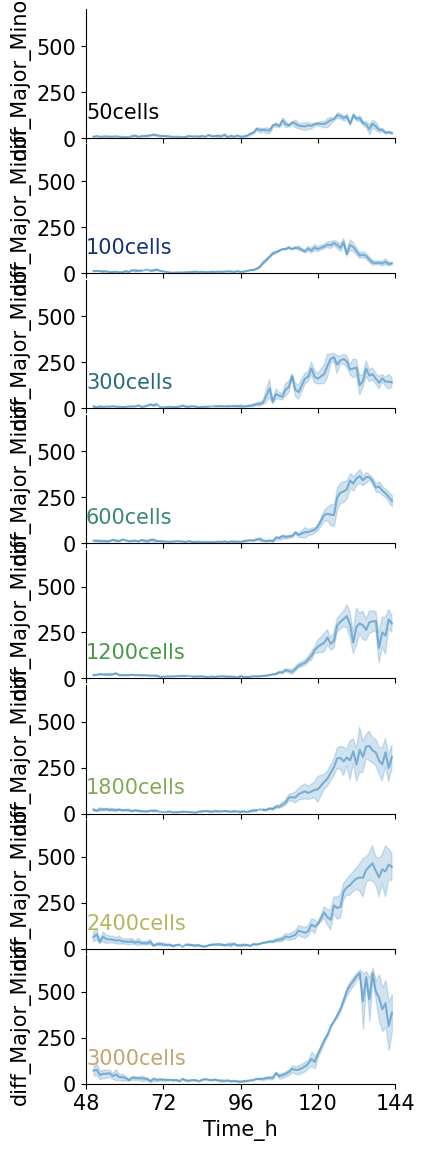

In [9]:
#Plotting with shift MAJOR - MINOR

df_analysis2 = add_diff_Major_Minor(df)
df_analysis2 = df.copy()
df_analysis2.insert(0,"diff_Major_Minor", " ")

for i in range(0,len(df_analysis2)):
    Major = df_analysis2.at[i,'Major_Axis_um']
    AR = df_analysis2.at[i,'AR']
    diff_Major_Minor = []
    for j in range(len(Major)):
         diff_Major_Minor.append(Major[j]-(Major[j] / AR[j]))
    
    #print(diff_Major_Minor)
    
    df_analysis2.at[i,'diff_Major_Minor'] =  diff_Major_Minor
    
    
    
#### First I need to reshape the data to be compatible with the seaborn format
df_analysis = df_analysis2.copy()
#Cond = df_analysis['Condition'].unique()
#Cond_list = Cond.astype('str')
Cond_list = np.array(['50cells','100cells','300cells','600cells','1200cells','1800cells','2400cells','3000cells'])
N_cond = Cond_list.size #Doubling to account for border vs center wells


# VARIABLE TO PLOT - in time
Colname = 'Major_Axis_um'
Colname = 'AR'

Colname = 'diff_Major_Minor'



n_t = len(Time)
ID_tot = np.empty(n_t*len(df_analysis), dtype='object')
V_tot = np.empty(n_t*len(df_analysis), dtype='object')
Cond_tot = np.empty(n_t*len(df_analysis), dtype='object')
Time_h_tot = np.empty(n_t*len(df_analysis), dtype='object')

n=0

for i in range(0,N_cond):
    R_i = df_analysis.loc[df_analysis['Condition']==Cond_list[i],Colname]
    R_i = R_i.values.tolist()
    P_i = np.empty((len(R_i),n_times))
    Well_list = df_analysis.loc[df_analysis['Condition']==Cond_list[i],'Well_ID']
    Well_list = Well_list.values.tolist()
    W_ID = np.array(Well_list)
    
    for j in range (0,len(R_i)):
        if (R_i[j]!=None):
            P_i[j,:] = R_i[j][0]
            peaks,_ = scipy.signal.find_peaks(P_i[j,:])

            P_i[j,peaks]=np.nan 
                        
    median_10 = np.nanmedian(P_i[:,0:10])
    med = np.nanmedian(P_i[:,0:10],axis=1)
    out1 = med<median_10/10
    out2 = med>median_10*10
    P_i[out1,:] = np.nan
    P_i[out2,:] = np.nan
    P= P_i[~np.isnan(P_i).all(axis=1),:]

    W_ID[out1] = 'N'
    W_ID[out2] = 'N'
    W_ID_in = np.delete(W_ID, np.argwhere(W_ID == 'N'))
    
    n_t = P.shape[1]
    
    IDs = np.tile(W_ID_in, n_t)
    V = np.reshape(P, ( n_t*len(W_ID_in)))
    Cond = np.full(n_t*len(W_ID_in),Cond_list[i])
    Time_h = np.tile(Time,len(W_ID_in))
    
    ID_tot[n:n+n_t*len(W_ID_in)] = IDs
    V_tot[n:n+n_t*len(W_ID_in)] = V
    Cond_tot[n:n+n_t*len(W_ID_in)] = Cond
    Time_h_tot[n:n+n_t*len(W_ID_in)] = Time_h
    

    n = n + n_t*len(W_ID_in)

	
df_plot = pd.DataFrame({'Well_ID': ID_tot[0:n], 'Condition': Cond_tot[0:n], 'Time_h': Time_h_tot[0:n], Colname:V_tot[0:n]})




colors = plt.cm.gist_earth(np.linspace(0,0.8,N_cond))

g = sns.FacetGrid(df_plot, row="Condition", hue="Condition", aspect=3, height=1.5, palette=colors)


g.map(sns.lineplot,"Time_h", 'diff_Major_Minor',"Condition",errorbar='se',alpha=0.5)
g.set(xlim=(48, 144), ylim=(0, 700), xticks=[48, 72, 96, 120, 144], yticks=[0, 250, 500])

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="normal", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Time_h")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=+.05)

# Remove axes details that don't play well with overlap
g.set_titles("")
 

name = '20230509_Exp1_Cut_shiftVertical'+Colname

#plt.savefig(name)